# Lending Club - Predicting loan application rejections

_We are trying to forecast the number of loans rejected per month using Arima Time Series and LTSM models_

https://www.lendingclub.com/info/download-data.action

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns


from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

_Import the Lending Club rejection Application Datae from the Lending Club website_

In [2]:
from glob import glob
loan = sorted(glob('RejectStats_201*.csv'))

In [3]:
loan

['RejectStats_2017Q1.csv',
 'RejectStats_2017Q2.csv',
 'RejectStats_2017Q3.csv',
 'RejectStats_2017Q4.csv',
 'RejectStats_2018Q1.csv',
 'RejectStats_2018Q2.csv',
 'RejectStats_2018Q3.csv',
 'RejectStats_2018Q4.csv',
 'RejectStats_2019Q1.csv']

In [4]:
loans = pd.concat((pd.read_csv(file,
                               low_memory=False,
                               skiprows=[0]).iloc[:, [1]]
                   for file in loan),
                  ignore_index=True)

In [5]:
loans.tail()

,Application Date
19158650,2019-03-31
19158651,2019-03-31
19158652,2019-03-31
19158653,2019-03-31
19158654,2019-03-31


In [6]:
loans.shape

(19158655, 1)

In [7]:
loans.to_csv('RejectedLoans.csv')

_Only import the application data as the data_

In [8]:
df = pd.read_csv('RejectedLoans.csv', index_col=0)

/Users/charla/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
df = df.dropna()

In [10]:
df.head()

,Application Date
0,2017-01-01
1,2017-01-01
2,2017-01-01
3,2017-01-01
4,2017-01-01


In [11]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158655 entries, 0 to 19158654
Data columns (total 1 columns):
Application Date    object
dtypes: object(1)
memory usage: 292.3+ MB


((19158655, 1), None)

_The forecast will be computed on a weekly basis_

In [12]:
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas#45281439
# http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Rejected_Loan_Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Rejected_Loan_Count'].sum().reset_index().sort_values('Application_Date')

In [13]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 2 columns):
Application_Date       118 non-null datetime64[ns]
Rejected_Loan_Count    118 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


((118, 2), None)

In [14]:
df.head()

,Application_Date,Rejected_Loan_Count
0,2016-12-26,19659
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717


In [15]:
# I will drop the 2016 date.
df = df.loc[1:, :]

In [16]:
df.head()

,Application_Date,Rejected_Loan_Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [17]:
df.tail()

,Application_Date,Rejected_Loan_Count
113,2019-02-25,190241
114,2019-03-04,189141
115,2019-03-11,210487
116,2019-03-18,206549
117,2019-03-25,174618


In [18]:
print(df[df.duplicated('Application_Date')])

Empty DataFrame
Columns: [Application_Date, Rejected_Loan_Count]
Index: []


In [19]:
df.shape

(117, 2)

_Our dataset is not down to 117 rows, which is 117 weeks of loan data._

_We will create a date based index(pd.to datetime)._

In [20]:
df['Application_Date'] = pd.to_datetime(df['Application_Date'])

_What is the time range of the data_

In [21]:
print("Starts date {}".format(df['Application_Date'].min()))
print("Ends date {}".format(df['Application_Date'].max()))

Starts date 2017-01-02 00:00:00
Ends date 2019-03-25 00:00:00


In [22]:
dfIndex = df.set_index('Application_Date')
dfIndex.index

DatetimeIndex(['2017-01-02', '2017-01-09', '2017-01-16', '2017-01-23',
               '2017-01-30', '2017-02-06', '2017-02-13', '2017-02-20',
               '2017-02-27', '2017-03-06',
               ...
               '2019-01-21', '2019-01-28', '2019-02-04', '2019-02-11',
               '2019-02-18', '2019-02-25', '2019-03-04', '2019-03-11',
               '2019-03-18', '2019-03-25'],
              dtype='datetime64[ns]', name='Application_Date', length=117, freq=None)

In [23]:
dfIndex.tail()

,Rejected_Loan_Count
Application_Date,
2019-02-25,190241
2019-03-04,189141
2019-03-11,210487
2019-03-18,206549
2019-03-25,174618


Let's use pandas to create a date based index.

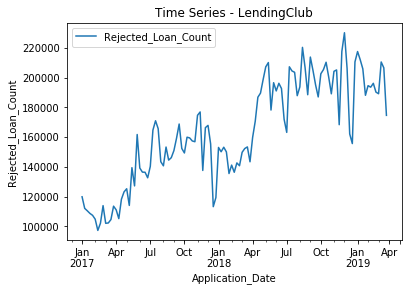

In [24]:
dfIndex.plot()
plt.title('Time Series - LendingClub')
plt.xlabel('Application_Date')
plt.ylabel('Rejected_Loan_Count')
plt.show()

_The data is not stationary, therefore we have to take the difference_

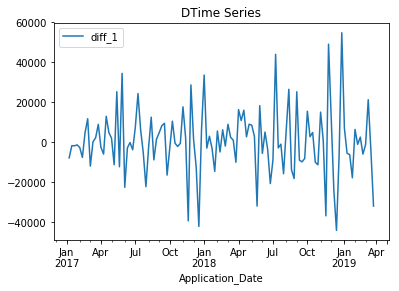

In [25]:
dfIndex['diff_1'] = dfIndex.Rejected_Loan_Count - \
    dfIndex.Rejected_Loan_Count.shift()
dfIndex.plot(y='diff_1')
plt.title('DTime Series')
plt.show()

In [26]:
dfIndex.head()

,Rejected_Loan_Count,diff_1
Application_Date,,
2017-01-02,119903,NaN
2017-01-09,112116,-7787.0
2017-01-16,110457,-1659.0
2017-01-23,108717,-1740.0
2017-01-30,107435,-1282.0


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
dfIndex = dfIndex.dropna()
dfIndex = dfIndex.drop('diff_1', axis=1)
decomposition = seasonal_decompose(dfIndex,
                                   model='additive')

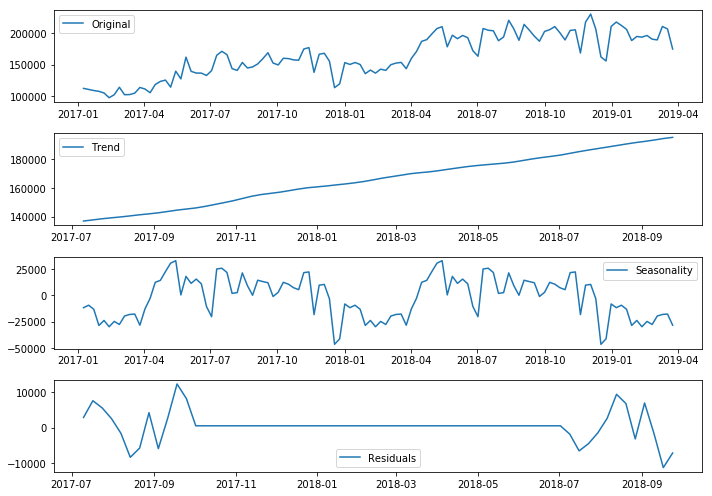

In [28]:
plt.figure(figsize=(10, 7))
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.subplot(411)
# plt.title('Original')
plt.plot(dfIndex.Rejected_Loan_Count, label='Original')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(412)
# plt.title('Trend')
plt.plot(trend, label='Trend')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(413)
# plt.title('Seasonality')
plt.plot(seasonal, label='Seasonality')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(414)
# plt.title('Residuals')
plt.plot(residuals, label='Residuals')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

_There is definetly a trend and seasonality in the data.  To handle the seasonality SARIMA will be used to forecast._


Here we can see that the trend and seasonality are separated out from data and we can model the residuals. 

In [29]:
dfIndex.tail(15)

,Rejected_Loan_Count
Application_Date,
2018-12-17,162124
2018-12-24,155657
2018-12-31,210521
2019-01-07,217498
2019-01-14,212040
2019-01-21,205848
2019-01-28,188093
2019-02-04,194570
2019-02-11,193545


----

### adfuller test

In [32]:
from statsmodels.tsa.stattools import adfuller

# raw data
acdf_test = adfuller(dfIndex['Rejected_Loan_Count'], autolag='AIC')
df_output = pd.Series(acdf_test[0:4], index=[
                      'Test Statistic',
                      'p-value',
                      '#lags used',
                      '#nobs used'])
print('raw data\n', df_output)
for k, v in acdf_test[4].items():
    print(k, v)

raw data
 Test Statistic     -1.653998
p-value             0.454956
#lags used          3.000000
#nobs used        112.000000
dtype: float64
1% -3.4901313156261384
5% -2.8877122815688776
10% -2.5807296460459184


_From this test, we see the time series is not stationary because the p-value is > 0.05_

### PACF for both the initial and differenced time series.

Text(0, 0.5, 'PACF')

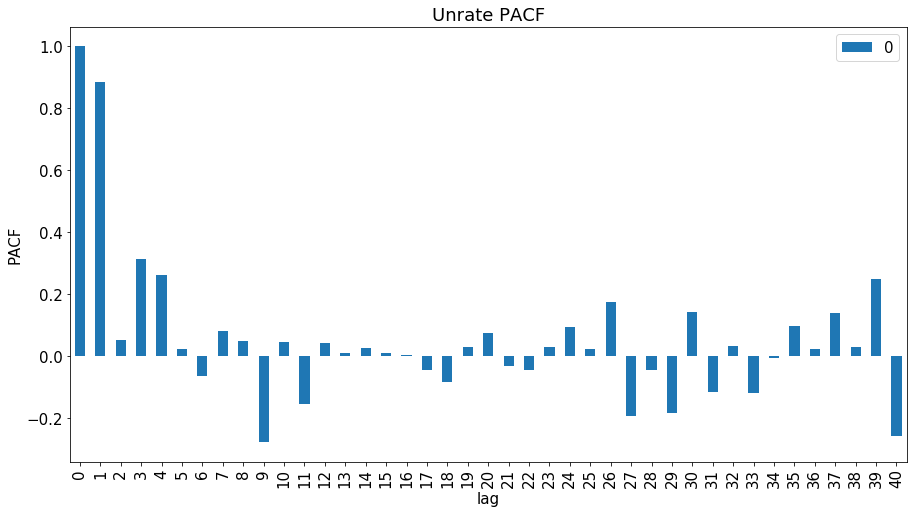

In [30]:
from statsmodels.tsa.stattools import pacf
# Plot Parameters
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams.update({'font.size': 15})
x_acf = pd.DataFrame(pacf(dfIndex.Rejected_Loan_Count))
x_acf.plot(kind='bar')
plt.title("Unrate PACF")
plt.xlabel('lag')
plt.ylabel('PACF')

Text(0, 0.5, 'diff PACF')

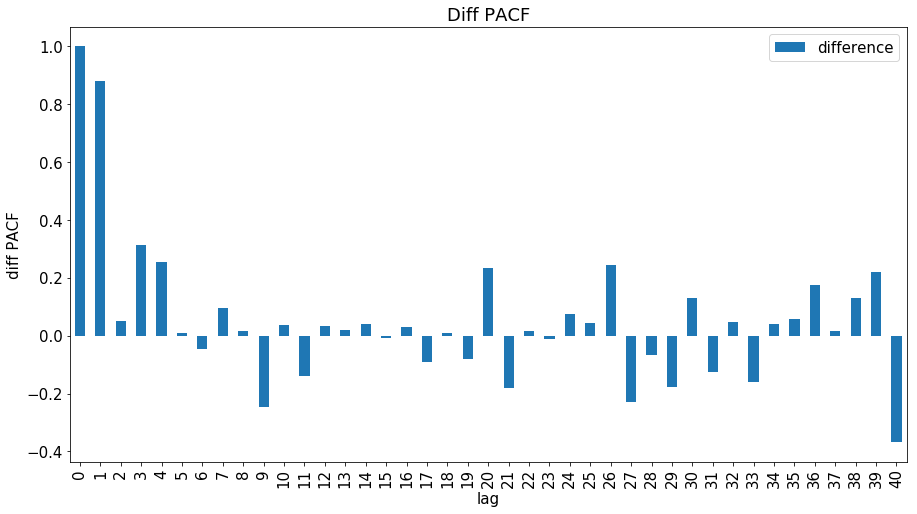

In [31]:
x_acf = pd.DataFrame(pacf(dfIndex.Rejected_Loan_Count.iloc[1:]))
x_acf.plot(kind='bar')
plt.title("Diff PACF")
plt.legend(['difference'])
plt.xlabel('lag')
plt.ylabel('diff PACF')

So both the original and the difference time series has 1 strong autocorrelation. This indicates that we should look into a p of 1 for our models.  I will try modeling with using the auto arima to see what the model comes up with.

ACF-coefficients of correlation between a time series and lags of itself
PACF-partial correlation coefficients between the series and lags of itself

Looking at the ACF and PACF plots of the differenced series we see our first significant value at lag 1 for ACF and at the same lag 1 for the PACF which suggest to use p = 1 and q = 1. We also have a big value at lag lag 3,4,9 in the plots which suggests our season is S = (3,4,9) and if the lag is positive it suggests P = 0 and Q = 1. Since this is a differenced series for SARIMA we set d = 1, and since the seasonal pattern is not stable over time we set D = 0. All together this gives us a SARIMA(0,1,4)(1,1,1)[9] model. Next we run SARIMA with these values to fit a model on our training data.

__Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)__
    * The ACF/PACF plots don't show a quick drop-off therefore it is not stationary.
    * This data is non-stationary as a high number of previous observations are correlated with future values.
    * Confidence intervals are the shaded area therefore any point outside is considered correlated.

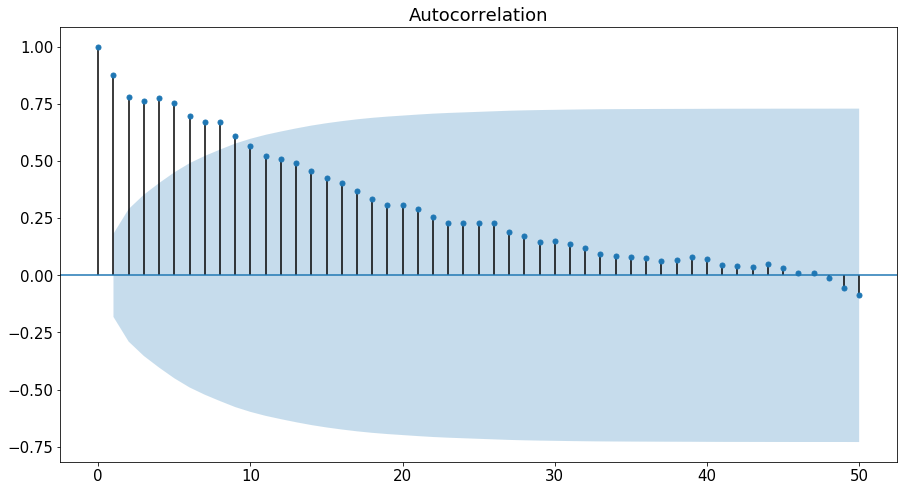

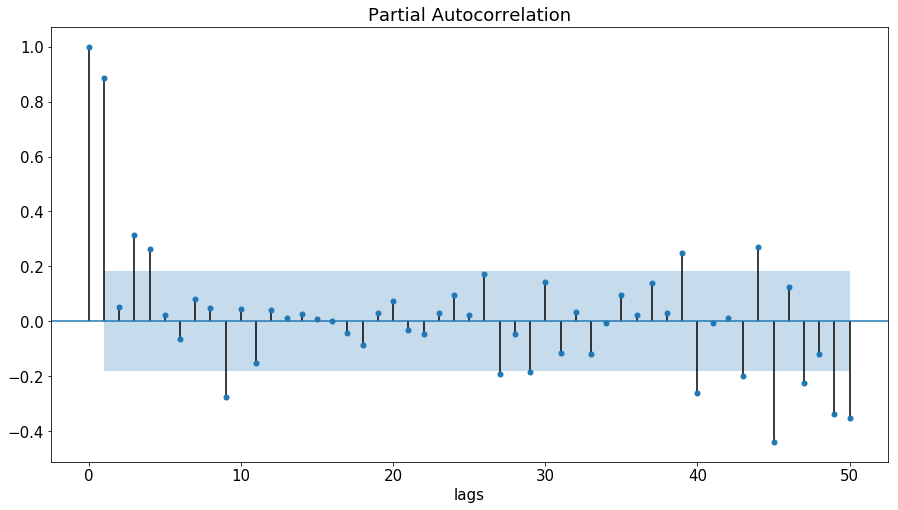

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(dfIndex['Rejected_Loan_Count'], lags=50)
plot_pacf(dfIndex['Rejected_Loan_Count'], lags=50)
plt.xlabel('lags')
plt.show()

## Building models.

So our both time series has 1 strong autocorrelation. Let's build some ARIMA models to experiment and see how we do!

We're going to build a series of models to evaluate, each with slightly different parameters for the ARIMA. Note that the parameteres are passed in (p, d, q) order, corresponding to the AR, I, and MA portions respectively.

Recall how we interpret those attributes. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

_Now we need to find the best model, one which has the lowesr AIC._

In [34]:
# https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(dfIndex['Rejected_Loan_Count'],
                            start_p=0, start_q=0,
                            max_p=13, max_q=13, m=13,
                            start_P=0, start_Q=0,
                            seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            random_state=42,
                            n_fits=3,
                            stepwise=True)
stepwise_model.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 13); AIC=2337.103, BIC=2342.353, Fit time=0.029 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 13); AIC=2301.396, BIC=2311.896, Fit time=0.141 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 13); AIC=2287.446, BIC=2297.945, Fit time=0.493 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=2287.025, BIC=2300.150, Fit time=0.298 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 13); AIC=2294.004, BIC=2304.504, Fit time=0.161 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 13); AIC=2328.712, BIC=2336.587, Fit time=0.054 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 13); AIC=229

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1134.857
Date:                            Sun, 14 Jul 2019   AIC                           2281.713
Time:                                    12:19:48   BIC                           2297.463
Sample:                                         0   HQIC                          2288.091
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -315.9325    725.235     -0.436      0.663   -1737.367    1105.502
ma.L1         -0.3026      0.238     -1.272      0.204      -0.769       0.164
ma.L2         -0.2153      0.198     -1.086      0.278      -0.604       0.173
ar.S.L13      -0.2300      0.210     -1.096      0.273      -0.641       0.181
ma.S.L13      -0.6329      0.261     -2.428      0.015      -1.144      -0.122
sigma2      4.291e+08      0.001   7.23e+11      0.000    4.29e+08    4.29e+08
===================================================================================
Ljung-Box (Q):                       38.70   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.53   Prob(JB):                         0.65
Heteroskedasticity (H):               1.30   Skew:                             0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.64e+27. Standard errors may be unstable.
"""

In [35]:
dfIndex.shape

(116, 1)

### Forecast : Holdout will be 8 weeks of data

_Separate out the train and test for modeling.  I will use 8 weeks of data for the test data which leaves 108 weeks for training._

_So the Test dates would be 2019-02-04 through 2019-3-25._

In [36]:
train, test = dfIndex[:108], dfIndex[108:]
train.shape, test.shape

((108, 1), (8, 1))

In [37]:
test(20)

,Rejected_Loan_Count
Application_Date,
2019-02-04,194570
2019-02-11,193545
2019-02-18,196149
2019-02-25,190241
2019-03-04,189141
2019-03-11,210487
2019-03-18,206549
2019-03-25,174618


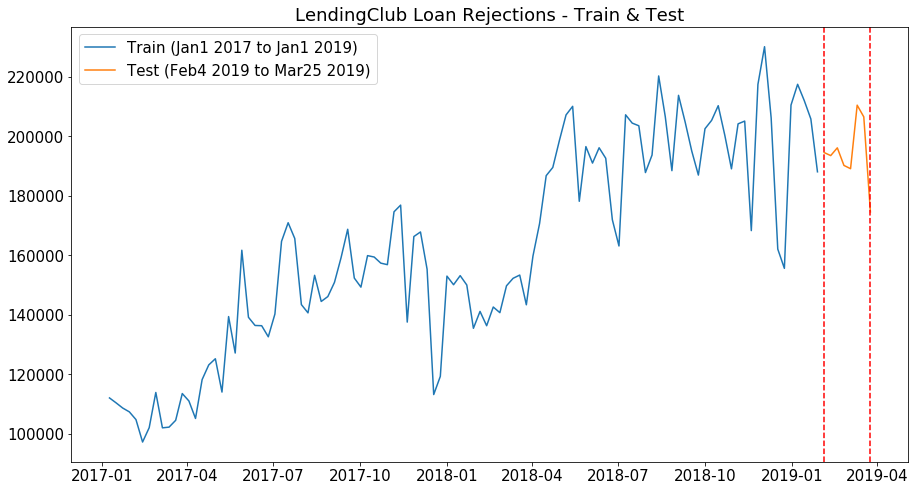

In [38]:
plt.plot(train, label='Train (Jan1 2017 to Jan1 2019)')
plt.plot(test, label='Test (Feb4 2019 to Mar25 2019)')
plt.title('LendingClub Loan Rejections - Train & Test')
plt.legend(loc='upper left')

xposition = ['2019-02-04', '2019-03-25']
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.show()

_The vertical markers represents the 8 weeks of test data, 2019-02-04 through 2019-3-25._

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Rejected_Loan_Count'], order=(0, 1, 2), seasonal_order=(
    1, 1, 1, 13), enforce_invertibility=True)
results = model.fit()
results.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Rejected_Loan_Count   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1044.654
Date:                            Sun, 14 Jul 2019   AIC                           2099.308
Time:                                    12:19:49   BIC                           2112.025
Sample:                                01-09-2017   HQIC                          2104.445
                                     - 01-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2829      0.204     -1.388      0.165      -0.682       0.117
ma.L2         -0.1902      0.179     -1.061      0.289      -0.541       0.161
ar.S.L13      -0.1997      0.212     -0.944      0.345      -0.614       0.215
ma.S.L13      -0.5822      0.255     -2.280      0.023      -1.083      -0.082
sigma2       3.93e+08   2.64e-10   1.49e+18      0.000    3.93e+08    3.93e+08
===================================================================================
Ljung-Box (Q):                       38.78   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.53   Prob(JB):                         0.43
Heteroskedasticity (H):               1.56   Skew:                             0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.24e+34. Standard errors may be unstable.
"""

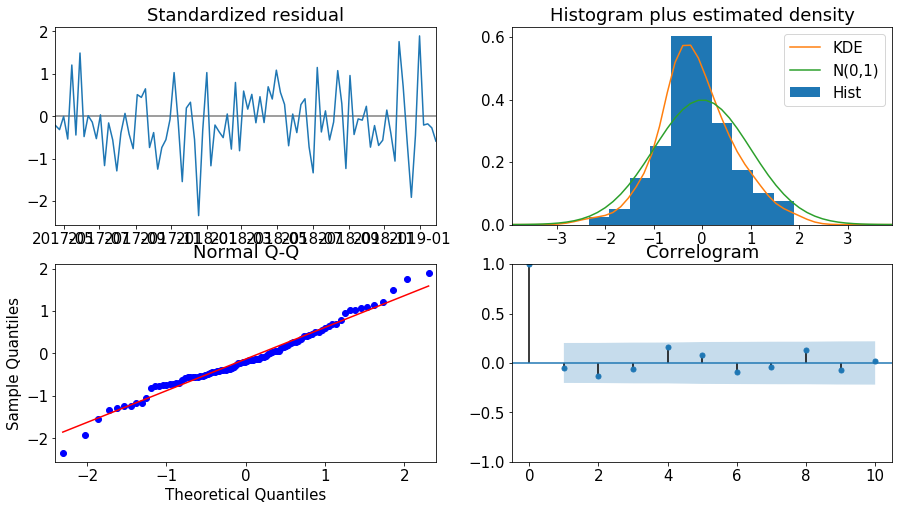

In [40]:
results.plot_diagnostics()
plt.show()

_The residuals look random and normaly distributed_

In [41]:
pred = pd.DataFrame(stepwise_model.predict(n_periods=8),
                    index=test.index)
pred.columns = ['Predicted_Num_Loans']

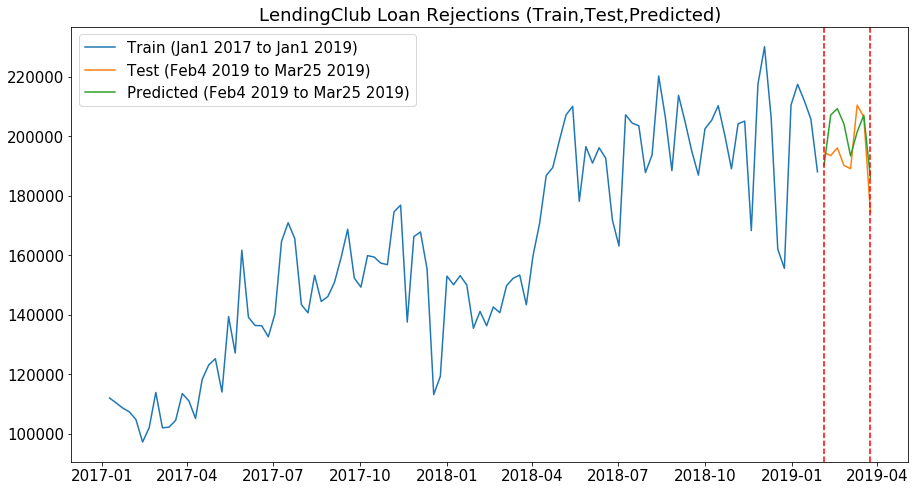

In [42]:
plt.title('LendingClub Loan Rejections (Train,Test,Predicted)')
plt.plot(train, label='Train (Jan1 2017 to Jan1 2019)')
plt.plot(test, label='Test (Feb4 2019 to Mar25 2019)')
plt.plot(pred, label='Predicted (Feb4 2019 to Mar25 2019)')
plt.legend(loc='upper left')
xposition = ['2019-02-04', '2019-03-25']
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.show()

In [43]:
test['Predicted_Count'] = pred
test['Error'] = test['Rejected_Loan_Count']-test['Predicted_Count']
test

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Rejected_Loan_Count,Predicted_Count,Error
Application_Date,,,
2019-02-04,194570,190282.514309,4287.485691
2019-02-11,193545,207165.140204,-13620.140204
2019-02-18,196149,209330.691465,-13181.691465
2019-02-25,190241,204185.997558,-13944.997558
2019-03-04,189141,193419.028761,-4278.028761
2019-03-11,210487,201513.062827,8973.937173
2019-03-18,206549,207129.721024,-580.721024
2019-03-25,174618,186142.098573,-11524.098573


In [44]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

actualMean = test['Rejected_Loan_Count'].sum() / test.shape[0]
print('Mean of Number of Loans: {:.2f}'.format(actualMean))

print('\nPredicted errors')
rmse = rmse(test['Predicted_Count'], test['Rejected_Loan_Count'])
mse = mean_squared_error(test['Predicted_Count'], test['Rejected_Loan_Count'])
print('Root Mean Square Error {:.2f}'.format(rmse))
print('Mean Squared Error {:.2f}'.format(mse))

percent_Mean_Error = (test['Rejected_Loan_Count'].sum() -
                      test['Predicted_Count'].sum())/(test.shape[0])


print('Percent Mean Error {:.2f}\n'.format(abs(percent_Mean_Error)))

print('The model is off by {:.2f}%.  \nThe with the mean number of loan = {:.2f}\nand the root mean square error of {:.2f}'
      .format(rmse/actualMean*100, actualMean, rmse))

Mean of Number of Loans: 194412.50

Predicted errors
Root Mean Square Error 10025.50
Mean Squared Error 100510732.85
Percent Mean Error 5483.53

The model is off by 5.16%.  
The with the mean number of loan = 194412.50
and the root mean square error of 10025.50


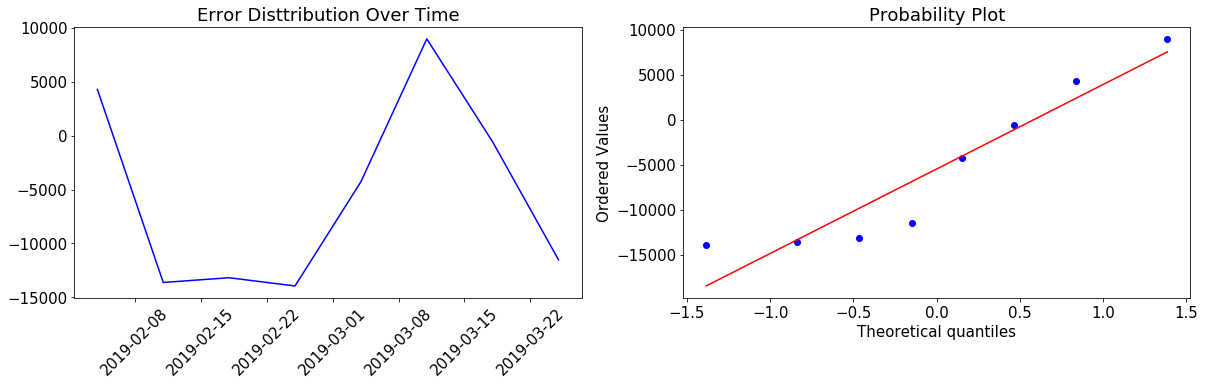

In [45]:
import pyramid as pm
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.xticks(rotation=45)
plt.plot(test.Error, color='blue')
plt.title('Error Disttribution Over Time')
plt.subplot(122)
scipy.stats.probplot(test.Error, plot=plt)

plt.show()

In [46]:
# Obtain predicted values
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(
    start=start, end=end, dynamic=False, typ='levels').rename('Predictions')

In [47]:
results_final = pd.DataFrame(predictions).join(test)

In [48]:
results_final.head(10)

,Predictions,Rejected_Loan_Count,Predicted_Count,Error
2019-02-04,200641.327599,194570,190282.514309,4287.485691
2019-02-11,212867.369212,193545,207165.140204,-13620.140204
2019-02-18,191871.735263,196149,209330.691465,-13181.691465
2019-02-25,202893.152409,190241,204185.997558,-13944.997558
2019-03-04,213443.527422,189141,193419.028761,-4278.028761
2019-03-11,206000.157074,210487,201513.062827,8973.937173
2019-03-18,190300.879568,206549,207129.721024,-580.721024
2019-03-25,181063.399260,174618,186142.098573,-11524.098573


In [49]:
results_final.Error.mean(), results_final.Rejected_Loan_Count.mean()

(-5483.531840232419, 194412.5)

The model did a decent job of predicting the loan rejections per week.  If we look at the first week, it was off by 4287 loans out of 200,400 or 

### Forecast for 12 weeks
_What does the forecast look like for 12 weeks?_

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dfIndex['Rejected_Loan_Count'], order=(0, 1, 2), seasonal_order=(
    0, 1, 1, 13), enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(dfIndex), len(dfIndex)+12,
                        typ='levels').rename('SARIMA 12 Week Forecast')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


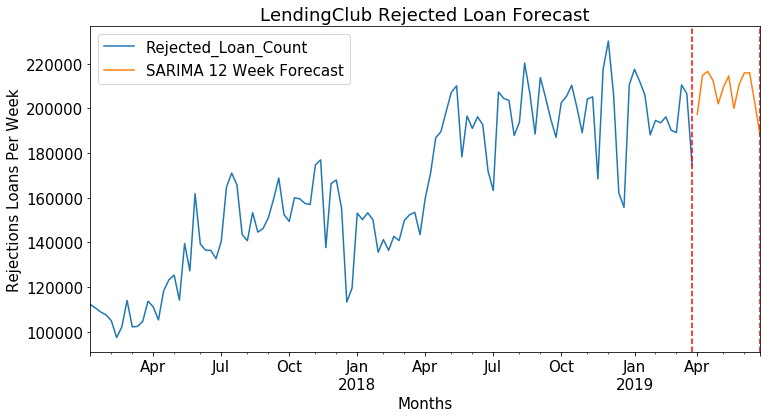

In [51]:
# Plot predictions against known values
import matplotlib.ticker as ticker
title = 'LendingClub Rejected Loan Forecast'
ylabel = 'Rejections Loans Per Week'
xlabel = 'Months'

ax = dfIndex['Rejected_Loan_Count'].plot(
    legend=True, figsize=(12, 6), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
xposition = ['2019-03-25', '2019-06-24']
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')

The 12 week forecast of rejected loans is seen in the plot above.  It looks to be on trend at about 200,000 loan applications rejected per week.  The forecast is for the weeks of March 26, 2019 to June 24, 2019. 

This forecast can be used to set weekly goals and expectations.  If you have a total number of loans weekly you can comebine the good and bad loan data to see what is the percentage of loans that are rejected and or approved.

--------------

# LSTM
We will use the same data for LSTM to predict 8 weeks of loans

LSTM is apable of learning long-term dependencies, remembering information for long periods of time. It consists of a chain of repeated moduls of neural networks.

The sigmod funcion helps to determine what to keep, if it is a 1 keep other wise get rid of it.

In [85]:
import pandas as pd

df = pd.read_csv('RejectedLoans.csv')
df = df.dropna()
df.shape

(19158655, 2)

In [86]:
df = df.drop('Unnamed: 0', axis=1)

In [87]:
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Rejected_Loan_Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Rejected_Loan_Count'].sum().reset_index().sort_values('Application_Date')

In [88]:
#df = df.dropna()
df = df.loc[1:, :]
df.shape

(117, 2)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 1 to 117
Data columns (total 2 columns):
Application_Date       117 non-null datetime64[ns]
Rejected_Loan_Count    117 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.7 KB


In [90]:
df.head()

,Application_Date,Rejected_Loan_Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [91]:
dataset = df.values

### Can LSTM predict 8 weeks of rejected loan applications?
_We will try to predict 8 weeks of loans.  There are 117 rows of data and each row represents a week of loans.  The train size is 109 weeks and the test siz is 8 weeks._

In [92]:
dataset_train, dataset_test = df[0:109], df[109:117]

In [93]:
training_set = dataset_train.iloc[:, 1:2].values
testing_set = dataset_test.iloc[:, 1:2].values

In [94]:
dataset_train.shape, dataset_test.shape, training_set.shape, testing_set.shape

((109, 2), (8, 2), (109, 1), (8, 1))

In [95]:
dataset_train.isna().sum()
dataset_test.isna().sum()

Application_Date       0
Rejected_Loan_Count    0
dtype: int64

In [96]:
dataset_test.head()

,Application_Date,Rejected_Loan_Count
110,2019-02-04,194570
111,2019-02-11,193545
112,2019-02-18,196149
113,2019-02-25,190241
114,2019-03-04,189141


Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1.

In [107]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [108]:
# create matrix
X_train = []
y_train = []
for i in range(8, 109):  # 8 time steps to figure out the next step
    X_train.append(training_set_scaled[i-8:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train,
                     (X_train.shape[0],
                      X_train.shape[1], 1))

In [109]:
X_test = []
y_test = []
for i in range(0, 8):
    X_test.append(testing_set_scaled[i-0:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [110]:
# matrix has 101 rows and 8 columns
# and trying to figure out the next step
# after the 8 time steps

# I am using the previous 8 time step(week) to predict the 9th time step(week)
X_train.shape, X_test.shape

((101, 8, 1), (8, 0, 1))

Again, I am predicting the next 2 months (8 weeks) of loan rejections (101,8,1).  This tells me I have 101 weeks of data and I am using the previous 8 weeks of data to predict the next week.

In [111]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
import time
NAME = "lendingClub8weeks{}".format(int(time.time()))

In [112]:
# to use tensorflow alpha install this
#!pip install --upgrade pip

In [164]:
#Set up tensorboard
#!pip3 install -U pip --user tensorflow
!rm -rf ./Users/charla/*jupyter_notebook_projects/logs/ #clear out logs
sess = tf.Session()
f = tf.summary.FileWriter(
    '/Users/charla/*jupyter_notebook_projects/logs/', sess.graph)

In [165]:
tf.keras.layers.LSTM
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

### LSTM setup
_To prevent overfitting (wrong connections) I will randomly disable some neurons(0.7). There are 3 layers with 1 output. It uses the Adam learning rate and 900 epoch(back and forths that are done)._

In [147]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=100,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(units=1))


lstm_model.compile(optimizer='adam',
                   loss='mean_squared_error')

history = lstm_model.fit(X_train,
                         y_train,
                         epochs=900,
                         batch_size=1,
                         callbacks=[tensorboard])

Epoch 1/300
101/101 [==============================] - 7s 71ms/step - loss: 0.0476
Epoch 2/300
101/101 [==============================] - 4s 37ms/step - loss: 0.0318
Epoch 3/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0238
Epoch 4/300
101/101 [==============================] - 4s 38ms/step - loss: 0.0252
Epoch 5/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0259
Epoch 6/300
101/101 [==============================] - 4s 37ms/step - loss: 0.0384
Epoch 7/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0224
Epoch 8/300
101/101 [==============================] - 3s 33ms/step - loss: 0.0267
Epoch 9/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0259
Epoch 10/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0260
Epoch 11/300
101/101 [==============================] - 4s 36ms/step - loss: 0.0220
Epoch 12/300
101/101 [==============================] - 4s 40ms/step - loss: 0.0254
E

101/101 [==============================] - 3s 33ms/step - loss: 0.0123
Epoch 99/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0124
Epoch 100/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0149
Epoch 101/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0152
Epoch 102/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0135
Epoch 103/300
101/101 [==============================] - 3s 33ms/step - loss: 0.0122
Epoch 104/300
101/101 [==============================] - 4s 36ms/step - loss: 0.0150
Epoch 105/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0150
Epoch 106/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0150
Epoch 107/300
101/101 [==============================] - 4s 43ms/step - loss: 0.0124
Epoch 108/300
101/101 [==============================] - 4s 38ms/step - loss: 0.0133
Epoch 109/300
101/101 [==============================] - 3s 32ms/step - loss: 0.

101/101 [==============================] - 3s 32ms/step - loss: 0.0067
Epoch 195/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0060
Epoch 196/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0064
Epoch 197/300
101/101 [==============================] - 4s 36ms/step - loss: 0.0046
Epoch 198/300
101/101 [==============================] - 4s 39ms/step - loss: 0.0056
Epoch 199/300
101/101 [==============================] - 4s 38ms/step - loss: 0.0050
Epoch 200/300
101/101 [==============================] - 3s 33ms/step - loss: 0.0047
Epoch 201/300
101/101 [==============================] - 4s 35ms/step - loss: 0.0043
Epoch 202/300
101/101 [==============================] - 3s 33ms/step - loss: 0.0043
Epoch 203/300
101/101 [==============================] - 3s 33ms/step - loss: 0.0052
Epoch 204/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0057
Epoch 205/300
101/101 [==============================] - 3s 32ms/step - loss: 0

101/101 [==============================] - 3s 31ms/step - loss: 0.0018
Epoch 291/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0025
Epoch 292/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0030
Epoch 293/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0024
Epoch 294/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0023
Epoch 295/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0018
Epoch 296/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0026
Epoch 297/300
101/101 [==============================] - 4s 36ms/step - loss: 0.0029
Epoch 298/300
101/101 [==============================] - 3s 34ms/step - loss: 0.0027
Epoch 299/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0028
Epoch 300/300
101/101 [==============================] - 4s 36ms/step - loss: 0.0016


In [148]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 8, 100)            40800     
_________________________________________________________________
dropout_29 (Dropout)         (None, 8, 100)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 8, 100)            80400     
_________________________________________________________________
dropout_30 (Dropout)         (None, 8, 100)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 8, 100)            80400     
_________________________________________________________________
dropout_31 (Dropout)         (None, 8, 100)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 100)               80400     
__________

In [149]:
true_loan_count = dataset_test.iloc[:, 1:2].values

In [150]:
true_loan_count

array([[194570],
       [193545],
       [196149],
       [190241],
       [189141],
       [210487],
       [206549],
       [174618]])

In [151]:
dataset_train.shape, dataset_test.shape

((109, 2), (8, 2))

In [152]:
dataset_total = pd.concat((dataset_train['Rejected_Loan_Count'],
                           dataset_test['Rejected_Loan_Count']),
                          axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 8:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
# inputs

In [153]:
X_test = []
for i in range(8, 16):
    X_test.append(inputs[i-8:i, 0])
    # y_test.append(inputs[i, 0])#added this to see if i can do eval on ten
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_loans = lstm_model.predict(X_test)
predicted_loans = sc.inverse_transform(predicted_loans)

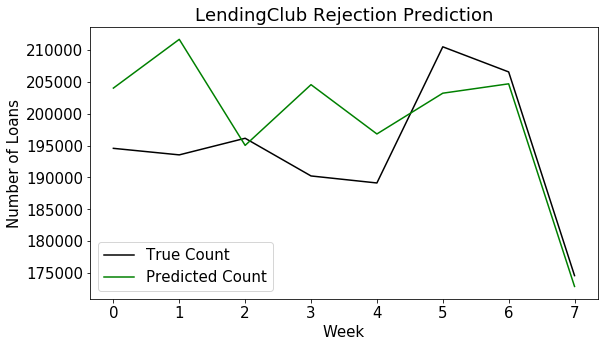

RMSE Train Score: 3717.63
MSE Train Score: 13820803.0497 

RMSE Test Score: 9627.7526 
MSE Test Score: 92693620.0280 


In [218]:
import math
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(true_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Week')
plt.ylabel('Number of Loans')
plt.legend()
plt.show()


# make predictions
trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])

testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'RMSE Train Score: {trainScore1:.2f}')
trainScore2 = mean_squared_error(trainY[0], trainPredict[:, 0])
print('MSE Train Score: %.4f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('\nRMSE Test Score: %.4f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:, 0])
print('MSE Test Score: %.4f ' % (testScore4))

_From the plot the model didn't do that well, it is overfitting.  It is predicting more rejections. The root mean square of the  actual and the predicted are not close at all._

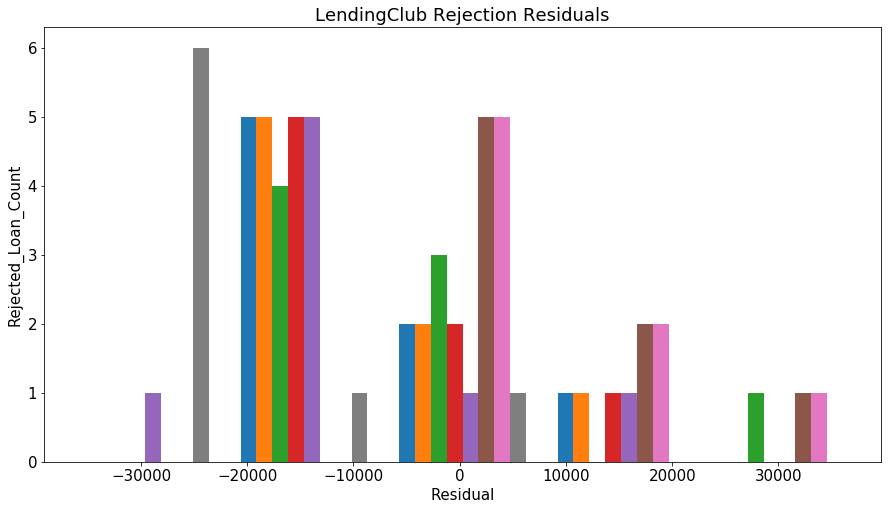

In [239]:
residual = testY - testPredict
plt.title('LendingClub Rejection Residuals')
plt.xlabel('Residual')
plt.ylabel('Rejected_Loan_Count')

plt.hist(residual,bins=5)
plt.show();

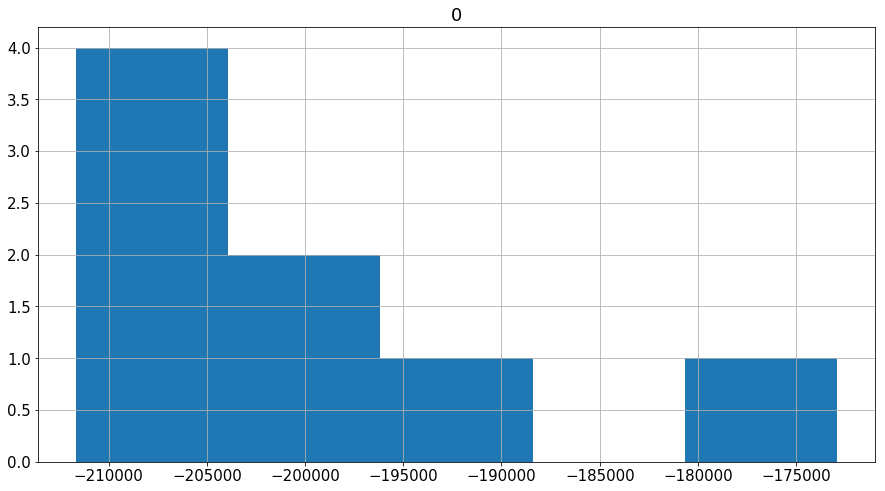

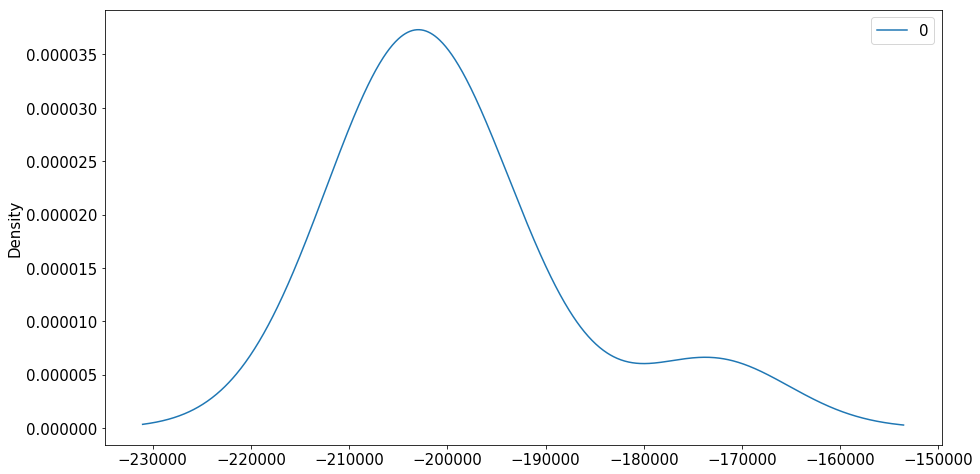

In [281]:
# calculate residuals
from pandas import DataFrame
resids = [testY[i]-testPredict[i] for i in range(len(testPredict))]
resids = DataFrame(resids)
resids=resids.dropna()
resids.hist(bins=5)
pyplot.show();

# density plot
resids.plot(kind='kde')
pyplot.show();

_We can see that the distribution does have a Gaussian look, that's right skewed, the mean is to the right of the median._

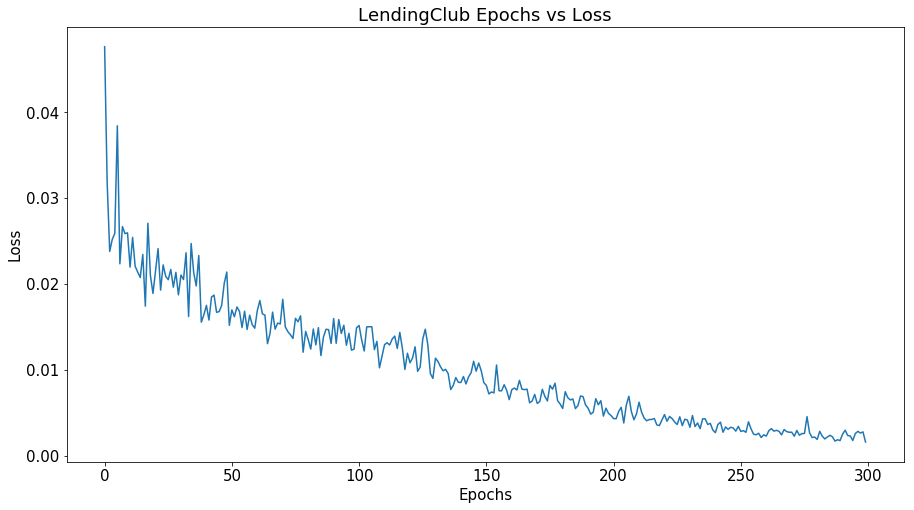

In [156]:
plt.title('LendingClub Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])

## TensorFlow2 alpha

In [157]:
#!pip install -q tf-nightly-2.0-preview

  ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [158]:
# Clear any logs from previous runs
#!rm -rf ./Users/charla/*jupyter_notebook_projects/logs/

In [160]:
#log_dir="logs/fit/"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [287]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True,
                               input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(X_train,
          y_train,
          epochs=900,
          batch_size=1)

model_score = model.evaluate(X_test, y_test)

Epoch 1/900
101/101 [==============================] - 11s 113ms/sample - loss: 0.0658
Epoch 2/900
101/101 [==============================] - 4s 38ms/sample - loss: 0.0403
Epoch 3/900
101/101 [==============================] - 4s 37ms/sample - loss: 0.0317
Epoch 4/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0288
Epoch 5/900
101/101 [==============================] - 4s 38ms/sample - loss: 0.0266
Epoch 6/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0338
Epoch 7/900
101/101 [==============================] - 3s 30ms/sample - loss: 0.0275
Epoch 8/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0267
Epoch 9/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0246
Epoch 10/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0229
Epoch 11/900
101/101 [==============================] - 4s 36ms/sample - loss: 0.0266
Epoch 12/900
101/101 [==============================] - 3s 34

101/101 [==============================] - 4s 38ms/sample - loss: 0.0176
Epoch 97/900
101/101 [==============================] - 4s 38ms/sample - loss: 0.0165
Epoch 98/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0150
Epoch 99/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0187
Epoch 100/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0159
Epoch 101/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0172
Epoch 102/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0152
Epoch 103/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0175
Epoch 104/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0136
Epoch 105/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0154
Epoch 106/900
101/101 [==============================] - 4s 40ms/sample - loss: 0.0160
Epoch 107/900
101/101 [==============================] - 4s 

101/101 [==============================] - 3s 30ms/sample - loss: 0.0117
Epoch 191/900
101/101 [==============================] - 4s 38ms/sample - loss: 0.0106
Epoch 192/900
101/101 [==============================] - 4s 37ms/sample - loss: 0.0136
Epoch 193/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0090
Epoch 194/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0111
Epoch 195/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0094
Epoch 196/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0113
Epoch 197/900
101/101 [==============================] - 4s 36ms/sample - loss: 0.0110
Epoch 198/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0093
Epoch 199/900
101/101 [==============================] - 3s 30ms/sample - loss: 0.0105
Epoch 200/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0101
Epoch 201/900
101/101 [==============================] - 

101/101 [==============================] - 4s 36ms/sample - loss: 0.0079
Epoch 285/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0067
Epoch 286/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0065
Epoch 287/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0053
Epoch 288/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0060
Epoch 289/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0058
Epoch 290/900
101/101 [==============================] - 4s 40ms/sample - loss: 0.0052
Epoch 291/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0061
Epoch 292/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0071
Epoch 293/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0064
Epoch 294/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0056
Epoch 295/900
101/101 [==============================] - 

101/101 [==============================] - 3s 34ms/sample - loss: 0.0039
Epoch 379/900
101/101 [==============================] - 3s 28ms/sample - loss: 0.0051
Epoch 380/900
101/101 [==============================] - 4s 37ms/sample - loss: 0.0037
Epoch 381/900
101/101 [==============================] - 3s 30ms/sample - loss: 0.0035
Epoch 382/900
101/101 [==============================] - 3s 29ms/sample - loss: 0.0038
Epoch 383/900
101/101 [==============================] - 3s 29ms/sample - loss: 0.0038
Epoch 384/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0050
Epoch 385/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0037
Epoch 386/900
101/101 [==============================] - 3s 29ms/sample - loss: 0.0045
Epoch 387/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0040
Epoch 388/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0041
Epoch 389/900
101/101 [==============================] - 

101/101 [==============================] - 3s 32ms/sample - loss: 0.0029
Epoch 472/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0025
Epoch 473/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0036
Epoch 474/900
101/101 [==============================] - 3s 30ms/sample - loss: 0.0031
Epoch 475/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0020
Epoch 476/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0022
Epoch 477/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0023
Epoch 478/900
101/101 [==============================] - 3s 30ms/sample - loss: 0.0031
Epoch 479/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0024
Epoch 480/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0029
Epoch 481/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0029
Epoch 482/900
101/101 [==============================] - 

101/101 [==============================] - 3s 34ms/sample - loss: 0.0021
Epoch 566/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0026
Epoch 567/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0021
Epoch 568/900
101/101 [==============================] - 4s 37ms/sample - loss: 0.0017
Epoch 569/900
101/101 [==============================] - 4s 35ms/sample - loss: 0.0021
Epoch 570/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0026
Epoch 571/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0019
Epoch 572/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0018
Epoch 573/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0028
Epoch 574/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0022
Epoch 575/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0030
Epoch 576/900
101/101 [==============================] - 

101/101 [==============================] - 3s 34ms/sample - loss: 0.0017
Epoch 660/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0022
Epoch 661/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0020
Epoch 662/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0020
Epoch 663/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0020
Epoch 664/900
101/101 [==============================] - 4s 35ms/sample - loss: 0.0019
Epoch 665/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0019
Epoch 666/900
101/101 [==============================] - 3s 30ms/sample - loss: 0.0029
Epoch 667/900
101/101 [==============================] - 4s 35ms/sample - loss: 0.0025
Epoch 668/900
101/101 [==============================] - 4s 36ms/sample - loss: 0.0016
Epoch 669/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0017
Epoch 670/900
101/101 [==============================] - 

101/101 [==============================] - 3s 33ms/sample - loss: 0.0015
Epoch 754/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0015
Epoch 755/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0017
Epoch 756/900
101/101 [==============================] - 4s 35ms/sample - loss: 0.0030
Epoch 757/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0025
Epoch 758/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0019
Epoch 759/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0016
Epoch 760/900
101/101 [==============================] - 3s 33ms/sample - loss: 0.0016
Epoch 761/900
101/101 [==============================] - 4s 36ms/sample - loss: 0.0017
Epoch 762/900
101/101 [==============================] - 4s 36ms/sample - loss: 0.0025
Epoch 763/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0014
Epoch 764/900
101/101 [==============================] - 

101/101 [==============================] - 3s 32ms/sample - loss: 0.0015
Epoch 848/900
101/101 [==============================] - 4s 39ms/sample - loss: 0.0012
Epoch 849/900
101/101 [==============================] - 4s 36ms/sample - loss: 0.0012
Epoch 850/900
101/101 [==============================] - 4s 38ms/sample - loss: 0.0014
Epoch 851/900
101/101 [==============================] - 4s 37ms/sample - loss: 0.0018
Epoch 852/900
101/101 [==============================] - 4s 35ms/sample - loss: 0.0016
Epoch 853/900
101/101 [==============================] - 3s 34ms/sample - loss: 0.0016
Epoch 854/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0014
Epoch 855/900
101/101 [==============================] - 3s 32ms/sample - loss: 0.0017
Epoch 856/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0015
Epoch 857/900
101/101 [==============================] - 3s 31ms/sample - loss: 0.0020
Epoch 858/900
101/101 [==============================] - 

In [288]:
print('Test loss:', model_score)

Test loss: 0.005328492261469364


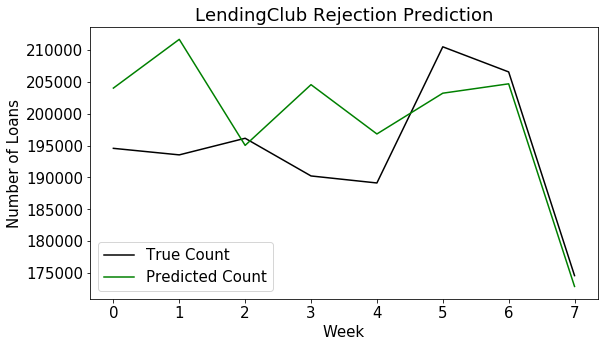

RMSE Train Score: 2108.22
MSE Train Score: 4444580.7007 

RMSE Test Score: 9696.4927 
MSE Test Score: 94021970.1748 


In [289]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(true_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Week')
plt.ylabel('Number of Loans')
plt.legend()
plt.show()


# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])

testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'RMSE Train Score: {trainScore1:.2f}')
trainScore2 = mean_squared_error(trainY[0], trainPredict[:, 0])
print('MSE Train Score: %.4f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('\nRMSE Test Score: %.4f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:, 0])
print('MSE Test Score: %.4f ' % (testScore4))

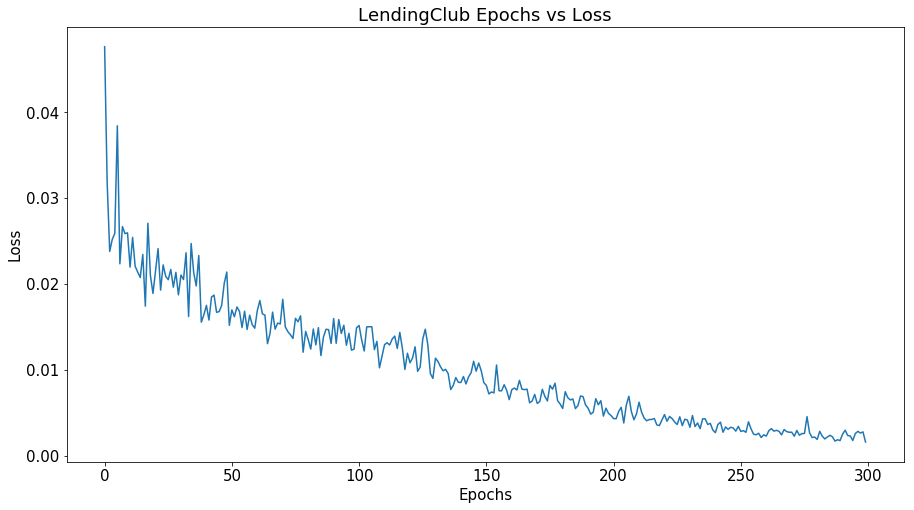

In [291]:
plt.title('LendingClub Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])